Assignment 1

## Part 1

[Linear baseline | 10-fold CV] RMSE=0.7093±0.0772MAE=0.5879±0.0592R2=-0.0688±0.0971
[Poly deg=2 | 10-fold CV] RMSE=0.5063±0.0630MAE=0.4255±0.0566R2=0.4468±0.1188
[Poly deg=3 | 10-fold CV] RMSE=0.5106±0.0650MAE=0.4289±0.0585R2=0.4354±0.1346
[Poly deg=4 | 10-fold CV] RMSE=0.3606±0.0494MAE=0.2997±0.0467R2=0.7185±0.0664
[Poly deg=5 | 10-fold CV] RMSE=0.3632±0.0518MAE=0.3039±0.0485R2=0.7149±0.0657
[Poly deg=6 | 10-fold CV] RMSE=0.2627±0.0311MAE=0.2104±0.0293R2=0.8487±0.0411
[Poly deg=7 | 10-fold CV] RMSE=0.2617±0.0304MAE=0.2077±0.0315R2=0.8498±0.0423
[Poly deg=8 | 10-fold CV] RMSE=0.2159±0.0388MAE=0.1745±0.0325R2=0.8946±0.0442
[Poly deg=9 | 10-fold CV] RMSE=0.2180±0.0371MAE=0.1762±0.0311R2=0.8928±0.0441
[Poly deg=10 | 10-fold CV] RMSE=0.2139±0.0329MAE=0.1749±0.0271R2=0.8967±0.0424
[Degree selection] Best degree = 10


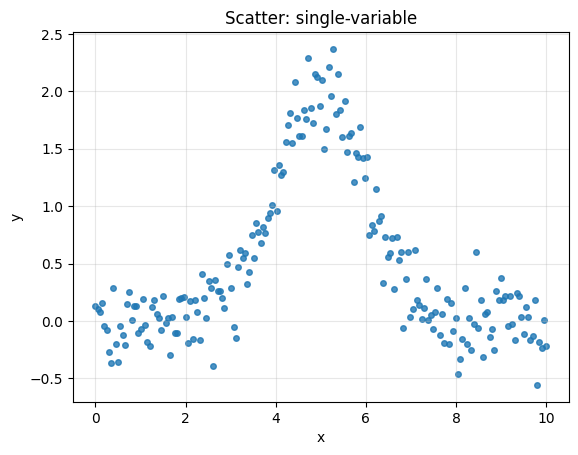

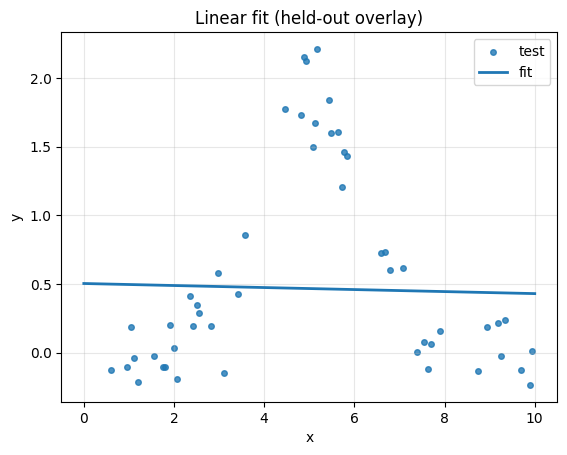

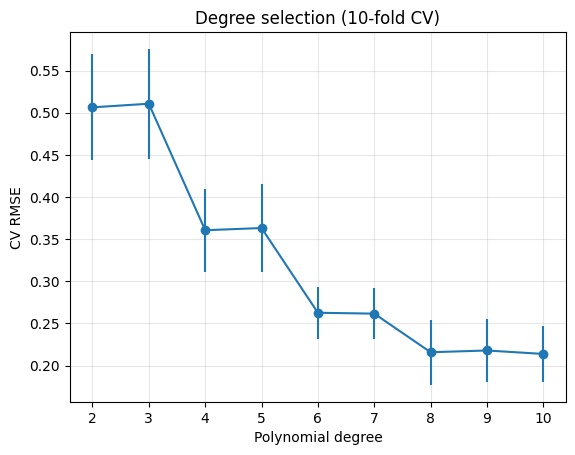

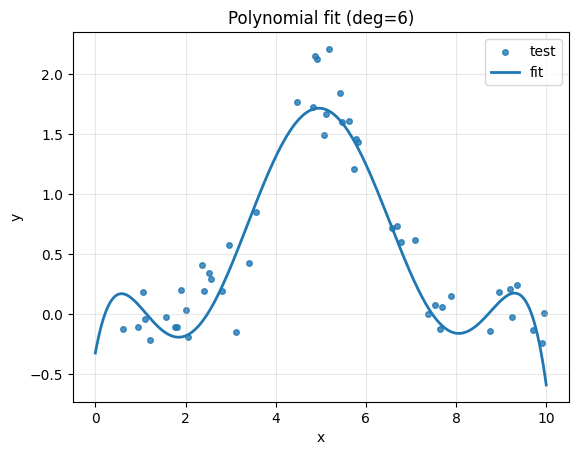

In [162]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
# Hardcoded settings
DATA_PATH = Path("data") / "svar-set3.csv"
OUTDIR = Path("out_q1_simple") # output folder
POLY_DEG = 6 # degree for overlay visualization
SEED = 42
OUTDIR.mkdir (parents=True, exist_ok=True)
# Metrics
def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((np.asarray(y_true) - np.asarray(y_pred))**2)))
rmse_scorer = make_scorer(lambda yt, yp: -rmse(yt, yp)) # sklearn wants higher=better
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)
#--  Utilities
def load_txt_dataset(path: str):

    arr = np.loadtxt(path, delimiter = ',')
    X, y = arr[:, :-1], arr[:, -1]
    return X, y
def print_cv(model, X, y, k=10, seed=42, label="model"):
    kf = KFold(n_splits=k, shuffle=True, random_state=seed)
    rmse_scores = -cross_val_score(model, X, y, scoring=rmse_scorer, cv=kf)
    mae_scores = -cross_val_score(model, X, y, scoring=mae_scorer, cv=kf)

#
    r2_scores = cross_val_score(model, X, y, scoring=r2_scorer, cv=kf)
    print(f"[{label} | {k}-fold CV] "
        f"RMSE={rmse_scores.mean():.4f}±{rmse_scores.std():.4f}"
        f"MAE={mae_scores.mean():.4f}±{mae_scores.std():.4f}"
        f"R2={r2_scores.mean():.4f}±{r2_scores.std():.4f}")
    return rmse_scores.mean(), rmse_scores.std()
def overlay_plot(Xtr, ytr, Xte, yte, model, outpath, title):
    model.fit(Xtr, ytr)
    xs = np.linspace(Xtr.min(), Xtr.max(), 300).reshape(-1, 1)
    ycurve = model.predict(xs)
    plt.figure()
    plt.scatter(Xte, yte, s=16, alpha=0.8, label="test")
    plt.plot(xs, ycurve, lw=2, label="fit")
    plt.xlabel("x"); plt.ylabel("y");
    plt.grid(alpha=0.3); plt.legend()
    plt.title(title)
    plt.savefig(outpath, bbox_inches="tight")


# Main workflow
# 1) Load & scatter
def main():
    X, y = load_txt_dataset (DATA_PATH)
    assert X.shape[1] == 1, "Single-feature dataset expected"
    plt.figure()
    plt.scatter(X, y, s=16, alpha=0.8)
    plt.xlabel("x"); plt.ylabel("y"); plt.title("Scatter: single-variable")
    plt.grid(alpha=0.3)
    plt.savefig(OUTDIR / "01_scatter.png", bbox_inches="tight")
    # 2) Linear regression (baseline)
    linear_pipeline = Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("linreg", LinearRegression()) # replace with your solver later
        ])
        
    print_cv(linear_pipeline, X, y, k=10, seed=SEED, label="Linear baseline")
    # Overlay linear fit
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=SEED)
    overlay_plot(Xtr, ytr, Xte, yte, linear_pipeline,
                OUTDIR / "02_overlay_linear.png",
                title="Linear fit (held-out overlay)")
    # 3-4) Polynomial degree selection
    degrees = list(range(2, 11)) 
    means, stds = [], []
    for d in degrees:
        poly_pipeline = Pipeline([
            ("scaler", StandardScaler (with_mean=True, with_std=True)),
            ("poly", PolynomialFeatures (degree=d, include_bias=False)),
            ("linreg", LinearRegression())
        ])
        m, s = print_cv(poly_pipeline, X, y, k=10, seed=SEED, label=f"Poly deg={d}")
        means.append(m); stds.append(s)
    # print(means)
    plt.figure()
    plt.errorbar (degrees, means, yerr=stds, marker="o")
    plt.xlabel("Polynomial degree"); plt.ylabel("CV RMSE")
    plt.title("Degree selection (10-fold CV)")
    plt.grid(alpha=0.3)
    plt.savefig(OUTDIR / "03_cv_degree.png", bbox_inches="tight")
    best_deg = degrees [int(np.argmin(means))]
    print(f"[Degree selection] Best degree = {best_deg}")
    # Overlay polynomial fit with chosen POLY_DEG
    best_poly = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("poly", PolynomialFeatures (degree=POLY_DEG, include_bias=False)),
        ("linreg", LinearRegression())
    ])
    
    overlay_plot(Xtr, ytr, Xte, yte, best_poly,
                OUTDIR / f"04_overlay_poly_deg{POLY_DEG}.png",
                title=f"Polynomial fit (deg={POLY_DEG})")
if __name__ == "__main__":
    main()
    
    

### 1.1
**Dataset: svar-set1**
- Complexity: The data appears to follow a linear trend. A degree of 6  will likely fit it best.
- Noise:The There is moderate amount of noise here. 

**Dataset: svar-set2**
- Complexity: The data appears to follow a polynomial trend. A degree 10 will likely fit it best .
- Noise: The noise level is high. 

**Dataset: svar-set3**
- Complexity: The data appears to follow a polynomial trend. A degree 10 will likely fit it best.
- Noise: The noise is high. There are few data clouds around the descent.

**Dataset: svar-set4**
- Complexity: The data appears to follow a polynomial trend. A degree 10 will fit it best.
- Noise: The noise is high. 

### 1.2

In [163]:
###Load data cell

X, y = load_txt_dataset(path = DATA_PATH)
X_train, X_te, y_tr, y_te  = train_test_split(X, y, test_size=0.25, random_state=SEED)
print(y_tr.shape)
X_tr_bias = np.c_[np.ones((X_train.shape[0], 1)), X_train]
X_te_bias = np.c_[np.ones((X_te.shape[0], 1)), X_te]




(150,)


**NORMAL EQUATION**

In [164]:


def solve_normal_equations(X, y, ridge =None):
    # X should be a prependeed with 1
    if ridge:
        
        theta = np.linalg.inv(np.transpose(X)@X + ridge*np.eye(X.shape[1]))@np.transpose(X)@y
    else:
        theta = np.linalg.inv(np.transpose(X)@X)@np.transpose(X)@y
    # print("theta", theta)
    return theta

ne_weights = solve_normal_equations(X_tr_bias, y_tr, 0)
y_hat = X_te_bias @ ne_weights #prediction



# print _cv()

**GRADIENT DESCENT**

[np.float64(0.6950309935076404), np.float64(0.6845149403972277), np.float64(0.6747069195178891), np.float64(0.6655591195319278), np.float64(0.6570269577316835), np.float64(0.6490688620148108), np.float64(0.6416460675824509), np.float64(0.6347224273660828), np.float64(0.6282642352559759), np.float64(0.6222400612667696), np.float64(0.6166205978340812), np.float64(0.611378516490486), np.float64(0.606488334219957), np.float64(0.601926288837199), np.float64(0.5976702227824355), np.float64(0.5936994747633653), np.float64(0.589994778714382), np.float64(0.5865381695789312), np.float64(0.583312895454248), np.float64(0.5803033356688356), np.float64(0.5774949243920516), np.float64(0.5748740794022286), np.float64(0.5724281356649825), np.float64(0.5701452833968798), np.float64(0.568014510311576), np.float64(0.5660255477659912), np.float64(0.5641688205431531), np.float64(0.5624354000261355), np.float64(0.56081696053409), np.float64(0.5593057386068454), np.float64(0.5578944950389567), np.float64(0.55

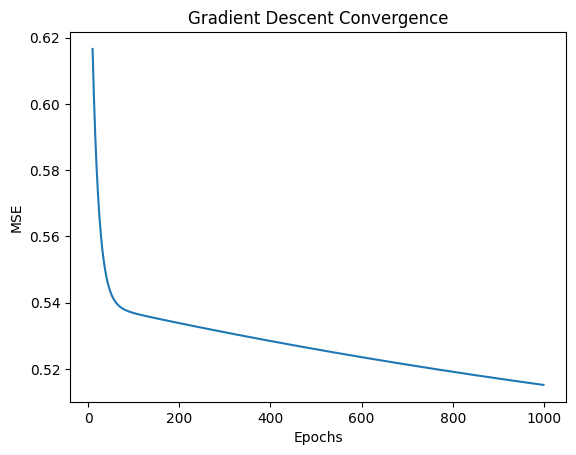

In [165]:

def solve_gradient_descent(X, y, lr = 0.001, epochs =1000): #lr: learning rate, epochs: no. of loops
    n = len(y)
    theta = np.zeros(X.shape[1])
    mse_history=[]
    
    for _ in range(epochs):
       
        y_hat = X @ theta # using this instead of y_hat = X(b) + a because it works better for multiple features
        # print(y_hat.shape)
        # print(y.shape)
        error = y_hat - y
        
        gradient = 1/n * (X.T @ error)       
        # Update weight
        theta = theta - (lr * gradient)
        
        # Track Progress
        current_mse = np.mean(error**2)
        mse_history.append(current_mse)
    # print(f"mse {mse_history[5:]}")
        
  
    return theta, mse_history
weights_gd, history = solve_gradient_descent(X_tr_bias, y_tr, epochs=1000 )

print(history)
print(f"GD Theta: {weights_gd}")

# [-0.02828941  2.00088856]

plt.plot(range(10, 1000), history[10:])
# plt.plot(range(5, 2000), history[5:])
# plt.yscale('log')
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Gradient Descent Convergence")
plt.show()

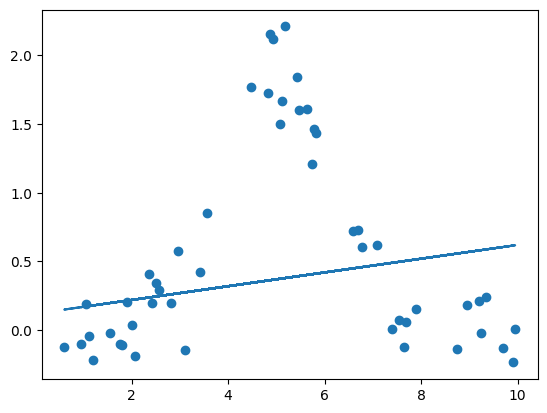

In [166]:
# def model(X, weights):
#     X_te_bias
predictions = X_te_bias @ weights_gd #final model

# print(predictions)
def plot(X, y, pred):
    plt.scatter(X, y, label = 'Data Points')
    plt.plot(X, pred)
    
plot(X_te, y_te, pred=predictions)

### 1.3
**evaluation**

In [167]:
def plot_manual_overlay(X_train, y_train, X_test, y_test, weights, title):
    plt.figure(figsize=(8, 6))
    
    # Plot the actual test data points
    plt.scatter(X_test, y_test, color='blue', s=16, alpha=0.8, label="Test Data")
    
    # Generate points for the line
    x_range = np.linspace(X_train.min(), X_train.max(), 300).reshape(-1, 1) 
    x_range_bias = np.c_[np.ones((x_range.shape[0], 1)), x_range]
    y_plot = x_range_bias @ weights
    
    # Plot the fitted line
    plt.plot(x_range, y_plot, color='red', lw=2, label="Fitted Line")
    
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

#### PLOT OVERLAY

In [168]:
def plot_overlay2(Xtr, ytr, Xte, yte, weights, train_means=None, train_stds=None, poly_deg=None, title="Overlay fit", label="fit"):
    Xtr = np.asarray(Xtr); Xte = np.asarray(Xte)
    ytr = np.asarray(ytr); yte = np.asarray(yte)
    if Xtr.ndim == 1: Xtr = Xtr.reshape(-1, 1)
    if Xte.ndim == 1: Xte = Xte.reshape(-1, 1)

    # derive raw x-values for plotting (inverse-transform if inputs are standardized)
    if train_means is not None and train_stds is not None:
        # assume column 0 corresponds to x^1
        mean0 = np.asarray(train_means)[0]
        std0  = np.asarray(train_stds)[0] if np.asarray(train_stds).shape[0] > 0 else 1.0
        std0 = std0 if std0 != 0 else 1.0
        Xtr_raw = Xtr[:, 0] * std0 + mean0
        Xte_raw = Xte[:, 0] * std0 + mean0
    else:
        Xtr_raw = Xtr[:, 0]
        Xte_raw = Xte[:, 0]

    x_min, x_max = Xtr_raw.min(), Xtr_raw.max()
    x_min = min(x_min, Xte_raw.min()); x_max = max(x_max, Xte_raw.max())
    xs = np.linspace(x_min, x_max, 200).reshape(-1, 1)

    if poly_deg:
        xs_poly = np.hstack([xs**d for d in range(1, poly_deg+1)])  # (200, poly_deg)
        if train_means is None or train_stds is None:
            raise ValueError("train_means and train_stds required when plotting poly fit")
        means = np.asarray(train_means)[:poly_deg]
        stds  = np.asarray(train_stds)[:poly_deg]
        stds_safe = np.where(stds == 0, 1.0, stds)
        xs_standard = (xs_poly - means) / stds_safe
        xs_bias = np.c_[np.ones((xs_standard.shape[0], 1)), xs_standard]
    else:
        xs_bias = np.c_[np.ones((xs.shape[0], 1)), xs]

    y_plot = xs_bias @ weights

    plt.figure()
    plt.scatter(Xte_raw, yte, s=16, alpha=0.8, label="test")
    plt.plot(xs, y_plot, color='C2', label=label)
    plt.title(title)
    plt.xlabel('x'); plt.ylabel('y')
    plt.legend(); plt.grid(alpha=0.3)
    plt.show()

#### K_FOLD

200
Gradient Descent | 10-fold CV: RMSE:0.7131±0.1266 MAE:0.5652± 0.1024 R2:-0.0663±0.0397
Normal Equation | 10-fold CV: RMSE:0.6996±0.1187 MAE:0.5834±0.0997 R2:-0.0289±0.0340


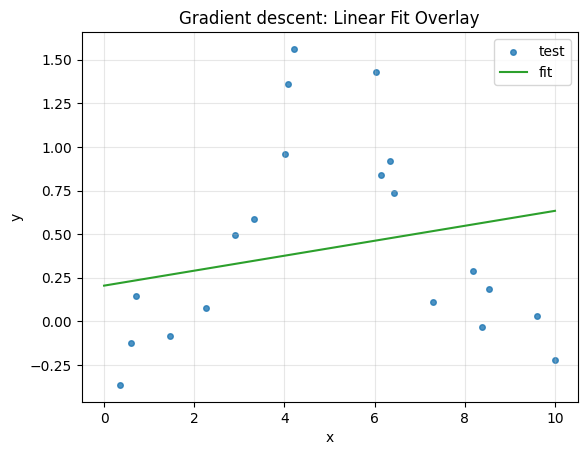

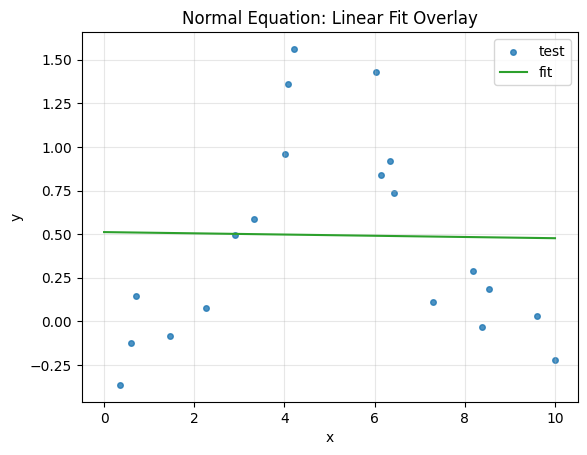

In [169]:
k=10
print(len(X))

def ten_fold_cross_validation(X, y, nm: bool = True, gd: bool = True, k = 10, ridge = None, percentages: float = None):

    rng = np.random.default_rng(seed = SEED)

    indices = rng.permutation(len(X))
    X_shuffled = X[indices]
    y_shuffled = y[indices]

    X_te = []
    X_train = []
    y_tr=[]
    x_split = np.array_split(X_shuffled, k)
    y_split = np.array_split(y_shuffled, k)
    # print(len(y_split))
    gd_rmse = []
    gd_mae = []
    gd_r2 = []
    # gd_weights = []
    ne_rmse = []
    ne_mae = []
    ne_r2 = []
    
    training_size = []
    for i in range(len(x_split)):
        # print(f"{i}",len(x_split))
        x_sub = x_split.copy()
        y_sub = y_split.copy()
        
        X_te = x_sub.pop(i)
        y_te = y_sub.pop(i)

        
        X_train = np.vstack(x_sub)
        
        y_tr = np.hstack(y_sub)
        
        if percentages:
            remove = int(len(X_train) * percentages )
            
            X_train = X_train[:-remove, :]
            y_tr = y_tr[:-remove]
            training_size.append(remove)
            # y_sub.pop(remove)
            # print(f"After removing x is {len(X_train)} shape {X_train.shape} y is {len(y_tr)} shape {y_tr.shape}\n {remove} was removed")
        X_tr_bias = np.c_[np.ones((X_train.shape[0],1)), X_train]
        X_te_bias = np.c_[np.ones((X_te.shape[0],1)), X_te]
        
        if gd:
            #Gradient Descent
            gd_weights, history = solve_gradient_descent(X_tr_bias, y_tr,0.001 ,2000)
            predictions = X_te_bias@gd_weights
            gd_rmse.append(rmse(y_te, predictions))
            gd_mae.append(mean_absolute_error(y_te, predictions))
            gd_r2.append(r2_score(y_true=y_te, y_pred=predictions))
        else:
            gd_weights = None
        if nm:
        ##Normal equation
            ne_weights = solve_normal_equations(X_tr_bias, y_tr, ridge)
            
            y_hat = X_te_bias @ ne_weights #prediction
            ne_rmse.append(rmse(y_te, y_hat))
            ne_mae.append(mean_absolute_error(y_te, y_hat))
            ne_r2.append(r2_score(y_true=y_te, y_pred=y_hat))
        else:
            ne_weights = None
        ##average
    gd_means = []
    gd_stds = []
    ne_means = []
    ne_stds = []
    gd_means_stds = {}
    ne_means_stds = {}
    # print(y_te)
    # print(y_tr)
    # Reporting results for Gradient Descent
    if gd:
        print(f"Gradient Descent | 10-fold CV:"\
        f" RMSE:{np.mean(gd_rmse):.4f}±{np.std(gd_rmse):.4f}"\
        f" MAE:{np.mean(gd_mae):.4f}± {np.std(gd_mae):.4f}"\
        f" R2:{np.mean(gd_r2):.4f}±{np.std(gd_r2):.4f}")
        gd_stds.append(np.std(gd_rmse))
        gd_means.append(np.mean(gd_rmse))
        
        gd_means_stds['means'] = gd_means
        gd_means_stds['stds'] = gd_stds
        # gd_stds.append(np.std(gd_rmse))
    # print("-" * 30)
    if nm:
    # Reporting results for Normal Equation
        print(f"Normal Equation | 10-fold CV:"\
        f" RMSE:{np.mean(ne_rmse):.4f}±{np.std(ne_rmse):.4f}"\
        f" MAE:{np.mean(ne_mae):.4f}±{np.std(ne_mae):.4f}"\
        f" R2:{np.mean(ne_r2):.4f}±{np.std(ne_r2):.4f}")
        ne_std = np.std(ne_rmse)
        ne_mean = np.mean(ne_rmse)
        # ne_stds.append(np.std(ne_rmse))
        # ne_means.append(np.mean(ne_rmse))
        # ne_means_stds['means'] = ne_means
        # ne_means_stds['stds'] = ne_stds
        
        # print(ne_means_stds)
    # print(gd_means_stds)
    # print(f"{gd_weights} , {ne_weights} , {X_train[0]}, {X_te[0]}")    
    
    result = {}
    result['gd_weights'] = gd_weights
    result['ne_weights'] = ne_weights
    result['X_train'] = X_train
    result['y_tr'] = y_tr
    result['X_te'] = X_te
    result['y_te'] = y_te
    result['ne_mean'] = ne_mean
    result['ne_std'] = ne_std
    result['gd_means'] = gd_means
    result['gd_stds'] = gd_stds
    result['tr_size'] = training_size
    return result

res = ten_fold_cross_validation(X=X, y=y)
plot_overlay2(res['X_train'], res['y_tr'], res['X_te'], res['y_te'],  res['gd_weights'], title = "Gradient descent: Linear Fit Overlay") 
plot_overlay2(res['X_train'], res['y_tr'], res['X_te'], res['y_te'], res['ne_weights'], title = "Normal Equation: Linear Fit Overlay") 
# plot_manual_overlay( "Normal Equation: Linear Fit Overlay") 

    


### 1.4

#### Polynomial Model

metric at degree[2] Xshape: (200, 2) lamda [1e-06]
Normal Equation | 10-fold CV: RMSE:0.5006±0.0919 MAE:0.4249±0.0811 R2:0.4655±0.1093
metric at degree[3] Xshape: (200, 3) lamda [1e-06]
Normal Equation | 10-fold CV: RMSE:0.5035±0.0918 MAE:0.4277±0.0815 R2:0.4595±0.1087
metric at degree[4] Xshape: (200, 4) lamda [1e-06]
Normal Equation | 10-fold CV: RMSE:0.3593±0.0562 MAE:0.2987±0.0466 R2:0.7201±0.0646
metric at degree[5] Xshape: (200, 5) lamda [1e-06]
Normal Equation | 10-fold CV: RMSE:0.3612±0.0565 MAE:0.3017±0.0457 R2:0.7174±0.0632
metric at degree[6] Xshape: (200, 6) lamda [1e-06]
Normal Equation | 10-fold CV: RMSE:0.2586±0.0325 MAE:0.2069±0.0209 R2:0.8515±0.0422
metric at degree[7] Xshape: (200, 7) lamda [1e-06]
Normal Equation | 10-fold CV: RMSE:0.2561±0.0332 MAE:0.2017±0.0200 R2:0.8526±0.0476
metric at degree[8] Xshape: (200, 8) lamda [1e-06]
Normal Equation | 10-fold CV: RMSE:0.2564±0.0324 MAE:0.2020±0.0192 R2:0.8526±0.0462
metric at degree[9] Xshape: (200, 9) lamda [1e-06]
Norm

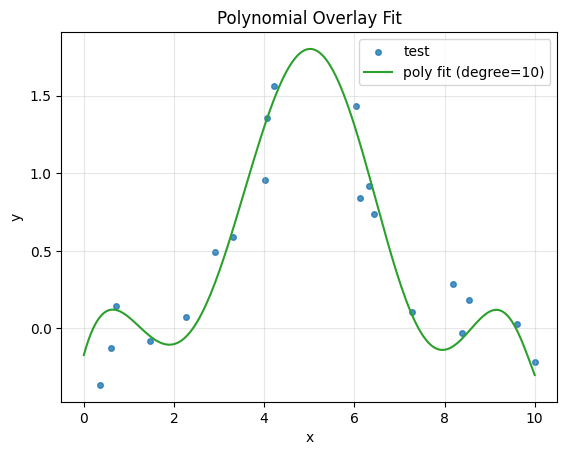

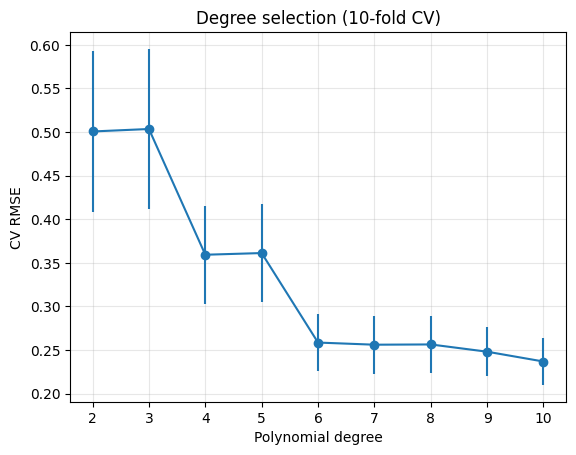

In [170]:
   
X_scalers = []
hold =[]
degree = 10

lin_ne_means = []
ne_stds = []
hold = [x for x in X]
X_temp = np.array(hold)
# print(scalers)

for d in range(2, degree+1):
    # print(f"{scalers[:,0] } ** {d}")
    column = d-2
    dergreed_X= (X_temp[:,0] ** d).reshape(-1, 1) 
    X_temp = np.hstack([X_temp, dergreed_X])
    
means = X_temp.mean(axis=0)   # shape (degree,)
stds  = X_temp.std(axis=0)     

i=0
while i < degree:
    mean_X = np.mean(X_temp[:, i])
    std_X = np.std(X_temp[:, i])
    
    standardize = (X_temp[:, i]-mean_X)/std_X
    X_scalers.append(standardize)
    scalers = np.column_stack(X_scalers)
    i += 1
    
    
# print(ne_stds)
max_deg = scalers.shape[1]
ne_weights_list = []
lamdas = [1e-6, 1e-4, 1e-2, 0.1, 1, 10]

for deg in range(2, max_deg+1):
    X_deg = scalers[:, :deg]

    lam  = 1e-6

    print(f"metric at degree[{deg}] Xshape: {X_deg.shape} lamda [{lam}]")


    res= ten_fold_cross_validation(X=X_deg, y=y, nm=True, gd=False, ridge = lam)
    ne_weights_list.append(res['ne_weights'])
    ne_stds.append(res['ne_std'])
    lin_ne_means.append(res['ne_mean'])
   
X_train = res['X_train']
degrees = list(range(2, degree + 1))

best_deg = degrees[int(np.argmin(lin_ne_means))]
print(f"[Degree selection] Best degree = {best_deg}")


train_means = means[:best_deg]
train_stds  = stds[:best_deg]
plot_overlay2(X_train, res['y_tr'], res['X_te'], res['y_te'], weights=ne_weights_list[best_deg-2],
              train_means=train_means, train_stds=train_stds, poly_deg=best_deg, title ="Polynomial Overlay Fit", label=f"poly fit (degree={best_deg})")

plt.figure()
plt.errorbar (degrees, lin_ne_means, yerr=ne_stds, marker="o")
plt.xlabel("Polynomial degree"); plt.ylabel("CV RMSE")
plt.title("Degree selection (10-fold CV)")
plt.grid(alpha=0.3)

 

The transition from linear to a degree 10 polynomial illustrates a successful **Bias-varaince tradeoff.** By increasing the model complexity, we reduced Bias 

### 1.5

In [171]:
def plot_error_bar(lin_means, lin_stds, poly_means, poly_stds):
    plt.figure(figsize=(10, 6))

    # Data for Linear Model (Normal Equation or GD)
    training_sizes = [144, 108, 72, 36] # Adjust based on your actual counts
    
    # Plotting both
    plt.errorbar(training_sizes, lin_means, yerr=lin_stds, label='Linear Model', fmt='-o', capsize=5)
    plt.errorbar(training_sizes, poly_means, yerr=poly_stds, label='Polynomial Model (Best Degree)', fmt='-s', capsize=5)

    plt.xlabel("Training Set Size (Number of Samples)")
    plt.ylabel("Mean CV-RMSE")
    plt.title("Data Ablation Study (Learning Curves)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

Gradient Descent | 10-fold CV: RMSE:0.7124±0.1266 MAE:0.5663± 0.1018 R2:-0.0640±0.0384
Normal Equation | 10-fold CV: RMSE:0.7016±0.1167 MAE:0.5895±0.0990 R2:-0.0363±0.0453
--------POLYNOMIAL--------
Gradient Descent | 10-fold CV: RMSE:0.6064±0.1134 MAE:0.4929± 0.0876 R2:0.2296±0.0623
Normal Equation | 10-fold CV: RMSE:0.2410±0.0254 MAE:0.1891±0.0219 R2:0.8699±0.0391

 After ablation: x is 144 and y is 144 20.0% was removed

Gradient Descent | 10-fold CV: RMSE:0.7108±0.1267 MAE:0.5647± 0.1035 R2:-0.0592±0.0419
Normal Equation | 10-fold CV: RMSE:0.7006±0.1167 MAE:0.5884±0.0994 R2:-0.0330±0.0400
--------POLYNOMIAL--------
Gradient Descent | 10-fold CV: RMSE:0.6070±0.1120 MAE:0.4881± 0.0861 R2:0.2278±0.0546
Normal Equation | 10-fold CV: RMSE:0.2452±0.0356 MAE:0.1935±0.0264 R2:0.8674±0.0362

 After ablation: x is 108 and y is 108 40.0% was removed

Gradient Descent | 10-fold CV: RMSE:0.7134±0.1268 MAE:0.5595± 0.1009 R2:-0.0671±0.0401
Normal Equation | 10-fold CV: RMSE:0.6986±0.1204 MAE:0.57

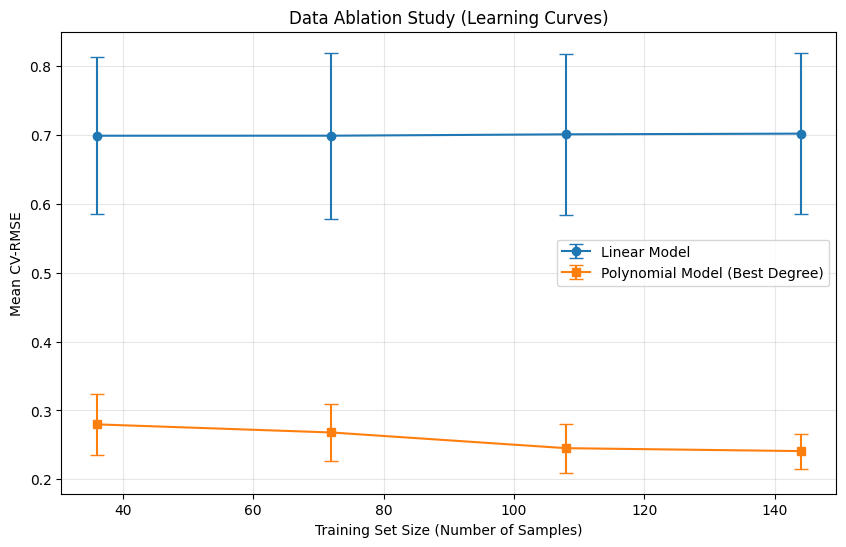

In [172]:
percentages = {0.20, 0.40, 0.60, 0.80}
lin_ne_means = []
lin_ne_std = []
pol_ne_means = []
pol_ne_std = []
X_deg = scalers[:, :best_deg]

for p in percentages:
    # print(p)
    # print(p * 190)
    res = ten_fold_cross_validation(X=X, y=y, nm=True, gd=True, ridge = lam, percentages=p)
    lin_remove = int(len(res['X_train']) * p)
    lin_ne_means.append(res['ne_mean'])
    lin_ne_std.append(res['ne_std'])
    # print(f"\n After ablation: x is {len(res['X_train'])} and y is {len(res['y_tr'])} {p*100}% was removed\n")
    print("--------POLYNOMIAL--------")
    res = ten_fold_cross_validation(X=X_deg, y=y, nm=True, gd=True, ridge = lam, percentages=p)
    poly_remove = int(len(res['X_train']) * p)
    pol_ne_means.append(res['ne_mean'])
    pol_ne_std.append(res['ne_std'])
    # polynomial_model(X, y, p, )
    
    print(f"\n After ablation: x is {len(res['X_train'])} and y is {len(res['y_tr'])} {p*100}% was removed\n")

plot_error_bar(lin_means=np.array(lin_ne_means), lin_stds=np.array(lin_ne_std), poly_means=np.array(pol_ne_means), poly_stds=np.array(pol_ne_std))
# print(200//10)

**observation:**
- The vertical error bars represent the standard deviation of RMS accross the 10 fold cross validation. After observing i can see the polynomial model is unstable at 40 trainng size, Conversely it is highly stable at 140 where the bar is shorter giving low rmse which indcates low variance. 


### 1.6

### Sklearn best
[Linear baseline | 10-fold CV] RMSE=0.2422±0.0509MAE=0.1755±0.0380R2=0.0589±0.2588
[Poly deg=10 | 10-fold CV] RMSE=0.0539±0.0119MAE=0.0426±0.0102R2=0.9509±0.0228
[Degree selection] Best degree = 10


### My best models
- **linear baseline** Normal Equation | 10-fold CV: RMSE:0.2393 ± 0.0636 MAE:0.1755 ± 0.0440 R2:0.0527 ± 0.3051
- **Polynnomial baseline** metric at degree[10] Xshape: (200, 10) lamda [0]
    - Normal Equation | 10-fold CV: RMSE:0.0555±0.0084 MAE:0.0431±0.0058 R2:0.9359±0.0450
    - [Degree selection] Best degree = 10


### Linear Model Comparison
**Observation:** A comparison of the baseline implementations shows the manual Normal Equation achieved a mean CV-RMSE of **0.2393**, slightly lower than the scikit-learn value of **0.2422**. However, scikit-learn demonstrates a lower standard deviation (0.0509 vs 0.0636), signifying higher variance in the manual implementation. The very low R² scores across both (~0.05) indicate significant underfitting (high bias); a linear function is fundamentally incapable of capturing the nonlinear oscillations present in this dataset.

### Polynomial Observation
**Observation:** Both polynomial models were evaluated at degree **10** and produce slightly different metrics. Scikit-learn yields a lower mean RMSE (**0.0539** vs **0.0555** for the manual model), but scikit-learn's RMSE shows a higher standard deviation (**0.0119** vs **0.0084**), indicating the manual implementation is slightly more stable across folds. This trend is similar across MAE and other metrics, except for R²: scikit-learn achieves **0.9509 ± 0.0228**, while the manual method yields **0.9359 ± 0.0450** — i.e., scikit-learn explains about **95.1%** of variance versus **93.6%** for the manual model.

## Part 2


(100000, 5),(100000,)
[Linear baseline | 10-fold CV] RMSE=0.0647±0.0009MAE=0.0455±0.0004R2=-0.0001±0.0002
[Poly deg=2 | 10-fold CV] RMSE=0.0623±0.0008MAE=0.0451±0.0004R2=0.0718±0.0039
[Poly deg=3 | 10-fold CV] RMSE=0.0624±0.0008MAE=0.0451±0.0004R2=0.0715±0.0038
[Degree selection] Best degree = 2


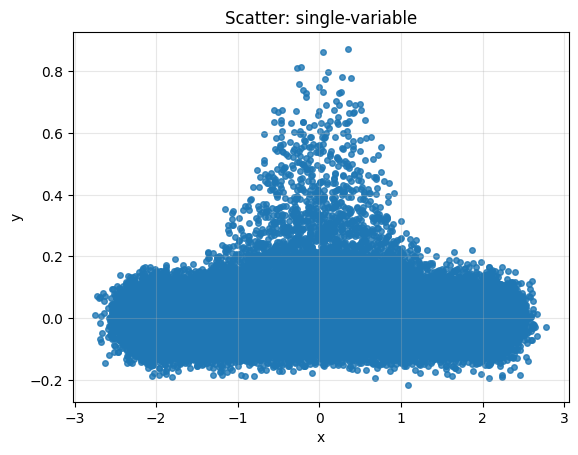

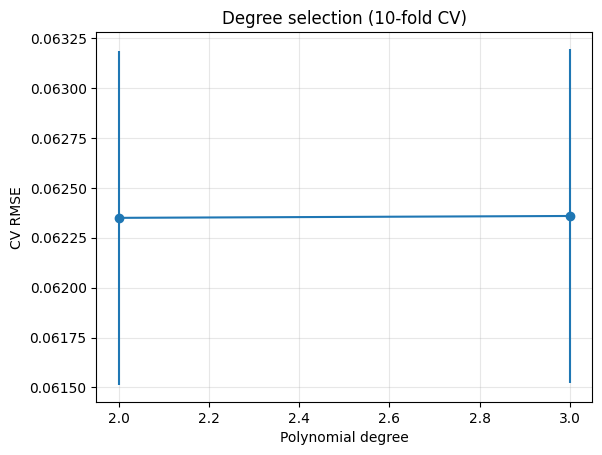

In [147]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score, train_test_split, cross_validate
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
# Hardcoded settings
DATA_PATH = Path("data") / "mvar-set4.csv"
OUTDIR = Path("out_q2_simple") # output folder
POLY_DEG = 6 # degree for overlay visualization
SEED = 42
OUTDIR.mkdir (parents=True, exist_ok=True)
# Metrics
def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((np.asarray(y_true) - np.asarray(y_pred))**2)))
rmse_scorer = make_scorer(lambda yt, yp: -rmse(yt, yp)) # sklearn wants higher=better
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)
#--  Utilities
def load_txt_dataset(path: str):

    arr = np.loadtxt(path, delimiter = ',')
    X, y = arr[:, :-1], arr[:, -1]
    return X, y
def print_cv(model, X, y, k=10, seed=42, label="model"):
    kf = KFold(n_splits=k, shuffle=True, random_state=seed)
    scoring = {'rmse': rmse_scorer, 'mae': mae_scorer, 'r2': r2_scorer}
    results = cross_validate(model, X, y, cv=kf, scoring=scoring)
    rmse_m = -results['test_rmse'].mean()
    rmse_s = results['test_rmse'].std() 
    # rmse_scores = -cross_val_score(model, X, y, scoring=rmse_scorer, cv=kf)
    mae_scores = -cross_val_score(model, X, y, scoring=mae_scorer, cv=kf)

#
    r2_scores = cross_val_score(model, X, y, scoring=r2_scorer, cv=kf)
    print(f"[{label} | {k}-fold CV] "
        f"RMSE={rmse_m:.4f}±{rmse_s:.4f}"
        f"MAE={mae_scores.mean():.4f}±{mae_scores.std():.4f}"
        f"R2={r2_scores.mean():.4f}±{r2_scores.std():.4f}")
    return rmse_m, rmse_s
def overlay_plot(Xtr, ytr, Xte, yte, model, outpath, title):
    model.fit(Xtr, ytr)
    xs = np.linspace(Xtr.min(), Xtr.max(), 300).reshape(-1, 1)
    ycurve = model.predict(xs)
    plt.figure()
    plt.scatter(Xte, yte, s=16, alpha=0.8, label="test")
    plt.plot(xs, ycurve, lw=2, label="fit")
    plt.xlabel("x"); plt.ylabel("y");
    plt.grid(alpha=0.3); plt.legend()
    plt.title(title)
    plt.savefig(outpath, bbox_inches="tight")


# Main workflow
# 1) Load & scatter
def main():
    X, y = load_txt_dataset (DATA_PATH)
    print(f"{X.shape},{y.shape}")
    # assert X.shape[1] == 1, "Single-feature dataset expected"
    plt.figure()
    plt.scatter(X[:,1], y, s=16, alpha=0.8)
    plt.xlabel("x"); plt.ylabel("y"); plt.title("Scatter: single-variable")
    plt.grid(alpha=0.3)
    plt.savefig(OUTDIR / "02_scatter.png", bbox_inches="tight")
    # 2) Linear regression (baseline)
    linear_pipeline = Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("linreg", LinearRegression()) # replace with your solver later
        ])
        
    print_cv(linear_pipeline, X, y, k=10, seed=SEED, label="Linear baseline")
    # # Overlay linear fit
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=SEED)
    # overlay_plot(Xtr, ytr, Xte, yte, linear_pipeline,
    #             OUTDIR / "02_overlay_linear.png",
    #             title="Linear fit (held-out overlay)")
    # 3-4) Polynomial degree selection
    degrees = list(range(2, 4)) 
    means, stds = [], []
    for d in degrees:
        poly_pipeline = Pipeline([
            ("scaler", StandardScaler (with_mean=True, with_std=True)),
            ("poly", PolynomialFeatures (degree=d, include_bias=False)),
            ("linreg", LinearRegression())
        ])
        m, s = print_cv(poly_pipeline, X, y, k=10, seed=SEED, label=f"Poly deg={d}")
        means.append(m); stds.append(s)
    # print(means)
    plt.figure()
    plt.errorbar (degrees, means, yerr=stds, marker="o")
    plt.xlabel("Polynomial degree"); plt.ylabel("CV RMSE")
    plt.title("Degree selection (10-fold CV)")
    plt.grid(alpha=0.3)
    plt.savefig(OUTDIR / "03_cv_degree.png", bbox_inches="tight")
    best_deg = degrees [int(np.argmin(means))]
    print(f"[Degree selection] Best degree = {best_deg}")
    # Overlay polynomial fit with chosen POLY_DEG
    best_poly = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("poly", PolynomialFeatures (degree=POLY_DEG, include_bias=False)),
        ("linreg", LinearRegression())
    ])
    
    # overlay_plot(Xtr, ytr, Xte, yte, best_poly,
    #             OUTDIR / f"04_overlay_poly_deg{POLY_DEG}.png",
    #             title=f"Polynomial fit (deg={POLY_DEG})")
if __name__ == "__main__":
    main()
    
    

### 2.1

**Observations**
- For `mvar-set1` the linear model and degree-2 polynomial models yield nearly identical mean RMSE and R² values. Because the linear model achieved this performance with significantly fewer features and shows a lower standard deviation across folds, it demonstrates better generalization stability. This suggests that the additional pairwise in the degree-2 map do not offer meaningful predictive power for this specifice dataset. 

- For `mvar-set2` degree-9 polynomial model yields a significantly lower RMSE `0.0508`  than the linear model `0.1411`. Consistent with R² `0.8985` at degree9  is huge jump from degree2 `0.2224`  the polynomial model, the standard deviation is consistently decreasing ehan the linear model's. This suggest it has a high variance, meaning it is highly stable with other datasets. The R² in polynomial models explains $89%$ of the data.

- For `mvar-set3` degree-2 polynomial model and linear model yield the exact same RMSE, MAE, R² with equal standard deviation. Determining the $R² = 0.97$ for both models, meaning $97%$ of the variance is explained. With a `0.0041` as the std of both RMSE proves that the models are highly stable.

- For `mvar-set4` observing the models show that the linear model has a $R^2$ of $-0.0001$ this suggest that the model is severely underfitting the data and is essentially failing to capture any of the underlying patterns. When we observe the polynomial degree trend we see that the there is a steady decrease from `0.0623`(degree 2) to `0.0555`(degree 6) shows that as we increase the polynomial degree, the model's capacity increases. . The standard deviation reflects an increase in value over the span of degree 1-6 This shows clear variance tradeoffs.

### 2.2

#### Pairwise product of X
**Objective**: We are going to perform a pairwise product on d featueres. Generating every combination of two features. The constraint is $i ≤ j$.

In [148]:
X, y = load_txt_dataset (DATA_PATH)


In [149]:
def pairwise_map(X):
    n_samples, n_features = X.shape
    var_thresh = 1e-6 #variance threshold
    features = [X] #original features
    #get indices for i <= j
    # gives us eht row and col indices for the upper triangle of a dxd matrix
    # ii, jj =np.triu_indices(n_features)
    for i in range(n_features):
       
        for j in range(i, n_features):
            
            features.append((X[:, i] * X[:, j]).reshape(-1,1))

            # print(f"{i} : {j}")
    pairwise_mapped = np.hstack(features)
    for i in range(n_features):
        for j in range(i, n_features):
            for k in range(j, n_features):
                features.append((X[:, i] * X[:, j] * X[:, k]).reshape(-1, 1))
    Z = np.hstack(features)
    
    
    z_samples, z_features = Z.shape
    for i in range(z_features):
        if np.var(Z[: ,i]) < var_thresh:
            print("Controlling explosion 💥")
            np.delete(Z, i, axis=1)
    print(z_features)
        
    # print(range(Z))
    return Z, pairwise_mapped
Z_deg3, Z_pairwise = pairwise_map(X)

# print(Z.shape)
    

55


### 2.3

#### Fitting OLS spaces using both 
 - normal equation and Gradient based solver

In [150]:
##train test split 


In [151]:
import time
import pandas as pd
from pandas import DataFrame as df

In [152]:
def solve_normal_equation(Z, y , lam: int = 1e-8):
    
    theta = np.linalg.inv((Z.T @ Z + lam*np.eye(Z.shape[1]))) @ Z.T @ y

    return theta

In [153]:
def solve_gradient_descent(X, y,lr=0.01,epochs =1000 ):
    n = len(X)
    ɵ = np.zeros(X.shape[1])
    mse_history = []
    
   
    for _ in range(epochs):
        y_hat = X @ ɵ
        error = y_hat - y
        #gradient
        gradient = 1/n * (X.T @ error)
        
        #update
        ɵ = ɵ  - (lr*gradient)
        mse_history.append(np.sum(error**2))
   
    return ɵ, mse_history 

In [154]:

results_list = []
Z_deg3, Z_pairwise = pairwise_map(X)
mappings = {"Pairwise": Z_pairwise, "Total Degree 3": Z_deg3}
solvers = ["Normal Equations", "Gradient Descent"]

for map_name, Z_data in mappings.items():
    Z_train, Z_test, y_train, y_test = train_test_split(Z_data, y, test_size=0.2, random_state=SEED)
    Z_tr_bias = np.c_[np.ones(Z_train.shape[0]), Z_train]
    Z_te_bias = np.c_[np.ones(Z_test.shape[0]), Z_test]
    
    for solver_name in solvers:
        # Measure Wall-clock time
        start = time.perf_counter()
        
        if solver_name == "Normal Equations":
  
            
            theta = solve_normal_equation(Z_tr_bias, y_train, lam=1e-8)
        else:
    
            theta, history = solve_gradient_descent(Z_tr_bias, y_train)
            
        end = time.perf_counter()
        elapsed = end - start
 
        y_pred = Z_te_bias @ theta
        
        current_rmse = rmse(y_test, y_pred)
        
        results_list.append({
            "Mapping": map_name,
            "Solver": solver_name,
            "Test RMSE": round(current_rmse, 6),
            "Time (sec)": round(elapsed, 6)
        })

55


In [ ]:
# # Create the DataFrame
# df_results = pd.DataFrame(results_list)

# # Display the table
# print(f"\n--- Question 2.3 Performance Comparison ({DATA_PATH})---")
# print(df_results.to_string(index=False))


# best_model = df_results.loc[df_results['Test RMSE'].idxmin()]
# print(f"\nFinal Model Selection: {best_model['Mapping']} with {best_model['Solver']}")


--- Question 2.3 Performance Comparison (data\mvar-set4.csv)---
       Mapping           Solver  Test RMSE  Time (sec)
      Pairwise Normal Equations   0.061822    0.026773
      Pairwise Gradient Descent   0.062006    1.648835
Total Degree 3 Normal Equations   0.061823    0.102524
Total Degree 3 Gradient Descent   0.062006    4.107170

Final Model Selection: Pairwise with Normal Equations


#### Final model for mvar-set1 is: Final Model Selection: Pairwise with Normal Equations

| Mapping           | Solver             | Test RMSE | Time (sec) |
|-------------------|--------------------|-----------|------------|
| Pairwise          | Normal Equations   | 0.498901  | 0.010264   |
| Pairwise          | Gradient Descent   | 0.507750  | 0.770130   |
| Total Degree 3    | Normal Equations   | 0.498986  | 0.053225   |
| Total Degree 3    | Gradient Descent   | 0.555376  | 3.689584   |


#### Final model for mvar-set2 is: Total Degree 3 with Normal Equations

| Mapping           | Solver             | Test RMSE | Time (sec) |
|-------------------|--------------------|-----------|------------|
| Pairwise          | Normal Equations   | 0.147174  | 0.001196   |
| Pairwise          | Gradient Descent   | 0.147168  | 0.020233   |
| Total Degree 3    | Normal Equations   | 0.104157  | 0.000161   |
| Total Degree 3    | Gradient Descent   | 0.107661  | 0.017843   |

#### Final model for mvar-set3 is: Pairwise with Normal Equations

| Mapping           | Solver             | Test RMSE | Time (sec) |
|-------------------|--------------------|-----------|------------|
| Pairwise          | Normal Equations   | 0.498901  | 0.167978   |
| Pairwise          | Gradient Descent   | 0.507750  | 0.746192   |
| Total Degree 3    | Normal Equations   | 0.498986  | 0.160206   |
| Total Degree 3    | Gradient Descent   | 0.555376  | 3.988320   |

#### Final model for mvar-set3 is: Pairwise with Normal Equations

| Mapping           | Solver             | Test RMSE | Time (sec) |
|-------------------|--------------------|-----------|------------|
| Pairwise          | Normal Equations   | 0.498901  | 0.167978   |
| Pairwise          | Gradient Descent   | 0.507750  | 0.746192   |
| Total Degree 3    | Normal Equations   | 0.498986  | 0.160206   |
| Total Degree 3    | Gradient Descent   | 0.555376  | 3.988320   |
